In [1]:
import firebase_admin
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from firebase_admin import credentials, firestore
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import os
import json
from sklearn.model_selection import train_test_split

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
firebase_admin.initialize_app(cred)
db = firestore.client()


import logging
logging.basicConfig(filename='training_log.txt', level=logging.INFO, format='%(asctime)s - %(message)s')

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao', 'z']
ACTIVITIES = ['sit','walk','upstair']
CHUNK_SIZE = 1.375  # in seconds (can be a decimal)
SAMPLING_RATE = 100  # Hz
NUM_CLASSES = 3
OVERLAP = 0.5

In [20]:
def extract_features(chunk):
    """Extract features from a chunked acceleration segment with selected statistics."""
    feature_vector = []
    
    for axis in ['x', 'y', 'z']:
        data_series = pd.Series(chunk[axis])
        # Apply smoothing
        smoothed_data = data_series.rolling(window=5, min_periods=1).mean()
        feature_vector.extend([
            smoothed_data.mean(),                  # Mean
            smoothed_data.median(),                # Median
            smoothed_data.std(),                   # Standard Deviation
            smoothed_data.var(),                   # Variance
            smoothed_data.min(),                   # Minimum
            smoothed_data.max(),                   # Maximum
        ])
    return feature_vector

In [ ]:
# Filter data
def fetch_data_for_stephen(collection_name, activities, time_start=500, time_end=6000):
    data, docs = [], []
    person_name = "Stephen"
    
    for activity in activities:
        for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
            record = recording.to_dict()
            if 'acceleration' not in record:
                continue

            docs.append(record)
            df = pd.DataFrame(record['acceleration'])
            
            if 'time' in df.columns:
                filtered_df = df[(df['time'] >= time_start) & (df['time'] <= time_end)]
                data.append(filtered_df)
            else:
                raise ValueError("The 'acceleration' field must include a 'time' column.")
    return data, docs

# Fetch Stephen's data
training_data_raw, training_docs = fetch_data_for_stephen("training", ACTIVITIES)
testing_data_raw, testing_docs = fetch_data_for_stephen("testing", ACTIVITIES)

# Extract features using chunk_data_with_overlap
X_train, y_train = chunk_data_with_overlap(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP)
X_test, y_test = chunk_data_with_overlap(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP)

# Combine train and test for cross-validation (Stephen's data only)
X_all = np.concatenate([X_train, X_test], axis=0)
y_all = np.concatenate([y_train, y_test], axis=0)

# Normalize the features
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)

# Convert to torch tensors
X_all = torch.tensor(X_all, dtype=torch.float32)  # Shape: (n_samples, 18)
y_all = torch.tensor(y_all, dtype=torch.long)

In [23]:
def chunk_data_with_overlap(data_raw, docs, chunk_size, activities, sampling_rate, overlap=0.5):
    """Chunk raw acceleration data into smaller labeled segments using overlapping windows."""
    data, labels = [], []
    chunk_samples = int(chunk_size * sampling_rate)
    step = int(chunk_samples * (1 - overlap))  # compute step size based on overlap

    for i, df in enumerate(data_raw):
        # Slide over the data with the defined step
        for start in range(0, len(df) - chunk_samples + 1, step):
            end = start + chunk_samples     
            chunk = df.iloc[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)
            data.append(extract_features(chunk))
            labels.append(label)
    return np.array(data), np.array(labels)

# Use overlapping window chunking
X_train, y_train = chunk_data_with_overlap(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP)
X_test, y_test = chunk_data_with_overlap(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE, OVERLAP)

In [24]:
def chunk_data(data_raw, docs, chunk_size, activities, sampling_rate):
    """Split data into chunks and assign labels."""
    data, labels = [], []
    activity_distribution = np.zeros(len(activities))
    chunk_samples = int(chunk_size * sampling_rate)  # Convert time to sample count

    for i in range(len(data_raw)):
        num_chunks = len(data_raw[i]) // chunk_samples
        for j in range(num_chunks):
            start = j * chunk_samples
            end = start + chunk_samples
            x = list(data_raw[i]["x"])[start:end]
            y = list(data_raw[i]["y"])[start:end]
            z = list(data_raw[i]["z"])[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)

            activity_distribution[label] += 1
            data.append([x, y, z])
            labels.append(label)

    return data, labels, activity_distribution


#training_data, training_labels, training_distribution = chunk_data(training_data_raw, training_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)
#testing_data, testing_labels, testing_distribution = chunk_data(testing_data_raw, testing_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

all_data_raw = training_data_raw + testing_data_raw
all_docs = training_docs + testing_docs
all_data, all_labels, all_distribution = chunk_data(all_data_raw, all_docs, CHUNK_SIZE, ACTIVITIES, SAMPLING_RATE)

indices = np.arange(len(all_data))
train, test = train_test_split(indices, test_size=0.2, random_state=42, stratify=all_labels)

training_data = [all_data[i] for i in train]
training_labels = [all_labels[i] for i in train]
testing_data = [all_data[i] for i in test]
testing_labels = [all_labels[i] for i in test]

training_distribution = np.bincount(training_labels, minlength=len(ACTIVITIES))
testing_distribution = np.bincount(testing_labels, minlength=len(ACTIVITIES))

In [25]:
from tabulate import tabulate #for table formatting

num_training_samples = len(training_data)
num_testing_samples = len(testing_data)

#table
summary_table = [["training", num_training_samples], ["testing", num_testing_samples]]

print("dataset summary:")
print(tabulate(summary_table, headers = ["Dataset", "number of chunks"], tablefmt="pretty"))

print("Training Activities Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}: {int(training_distribution[i])} chunks")

print("\nTesting Activity Count")
for i, activity in enumerate(ACTIVITIES):
    print(f"{activity}:{int(testing_distribution[i])} chunks")
print(len(training_data))
print(len(testing_data))
print(np.array(training_data).shape)
print(len(training_data_raw))
print(len(testing_data_raw))

dataset summary:
+----------+------------------+
| Dataset  | number of chunks |
+----------+------------------+
| training |        38        |
| testing  |        10        |
+----------+------------------+
Training Activities Count
sit: 13 chunks
walk: 13 chunks
upstair: 12 chunks

Testing Activity Count
sit:3 chunks
walk:3 chunks
upstair:4 chunks
38
10
(38, 3, 137)
6
6


In [26]:
# Modified CNN for extracted features
class FeatureCNNModel(nn.Module):
    def __init__(self, num_classes, input_features=18):
        super(FeatureCNNModel, self).__init__()

        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)  # Input: (batch, 1, 18)
        self.conv2 = nn.Conv1d(16, 32, kernel_size=3, padding=1)
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(32, 16)
        self.fc2 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.4)

        self.apply(self.initialize_weights)

    def initialize_weights(self, m):
        if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dim: (batch, 1, 18)
        x = F.silu(self.conv1(x))
        x = F.max_pool1d(x, 2, stride=1)  # Small pooling due to short sequence
        x = F.silu(self.conv2(x))
        x = self.global_pool(x).squeeze(-1)  # (batch, 32)
        x = F.silu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [27]:
BEST_MODEL_PATH = "best_model.pth"
BEST_METADATA_PATH = "best_model.json"

def save_best_model(epoch, model, optimizer, test_loss, train_losses, test_losses):
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'test_loss': test_loss,
        'train_losses': train_losses,
        'test_losses': test_losses
    }, BEST_MODEL_PATH)

    # Save metadata
    with open(BEST_METADATA_PATH, "w") as f:
        json.dump({"epoch": epoch, "test_loss": test_loss}, f)

def load_best_model(model, optimizer):
    if os.path.exists(BEST_MODEL_PATH) and os.path.exists(BEST_METADATA_PATH):
        checkpoint = torch.load(BEST_MODEL_PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        best_loss = checkpoint['test_loss']
        train_losses = checkpoint.get('train_losses', [])
        test_losses = checkpoint.get('test_losses', [])

        print(f"Loaded best model from epoch {start_epoch} with Avg Loss: {best_loss:.4f}")
        return start_epoch, best_loss, train_losses, test_losses
    return 0, float('inf'), 0.0, [], []  # Start fresh if no saved model

In [28]:
def evaluate_model(loader, model, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # disable gradient calc
        for data, targets in loader:
            outputs = model(data)
            loss = criterion(outputs, targets)
            total_loss += loss.item()

            # accuracy
            _, predicted = torch.max(outputs, 1)  # get predicted class (max value)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    avg_loss = total_loss / len(loader)
    accuracy = 100 * correct / total

    return avg_loss, accuracy

In [19]:
model = OptimizedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(CHUNK_SIZE * 100))
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay helps reduce overfitting
criterion = nn.CrossEntropyLoss()

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-4)

# Load best model if exists
#start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses = load_best_model(model, optimizer)
start_epoch, best_loss, best_avg_accuracy, train_losses, test_losses =  0, float('inf'), 0.0, [], []

In [32]:
# Cross-validation setup
n_folds = 5
kf = KFold(n_splits=n_folds, shuffle=True, random_state=42)
fold_accuracies = []
fold_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_all)):
    print(f'Fold {fold + 1}/{n_folds}')
    
    # Split data
    X_train_fold = X_all[train_idx]
    y_train_fold = y_all[train_idx]
    X_test_fold = X_all[val_idx]
    y_test_fold = y_all[val_idx]
    
    # Create data loaders
    train_dataset = TensorDataset(X_train_fold, y_train_fold)
    test_dataset = TensorDataset(X_test_fold, y_test_fold)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)
    
    # Initialize model
    model = FeatureCNNModel(num_classes=NUM_CLASSES, input_features=18)
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-4)
    
    # Training loop
    best_test_loss = float('inf')
    best_test_accuracy = 0
    train_losses = []
    test_losses = []
    
    for epoch in range(100):  # Reduced epochs for extracted features
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
        
        # Evaluate
        train_loss, train_accuracy = evaluate_model(train_loader, model, criterion)
        test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        # Log and print
        log_message = (f"Fold {fold+1} Epoch [{epoch+1}/100], "
                      f"Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, "
                      f"Test Loss: {test_loss:.4f}, Test Acc: {test_accuracy:.2f}%")
        logging.info(log_message)
        print(log_message)
        
        # Save best model
        if test_accuracy > best_test_accuracy:
            best_test_accuracy = test_accuracy
            best_test_loss = test_loss
            save_best_model(epoch, model, optimizer, test_loss, train_losses, test_losses)
    
    # Store fold results
    fold_accuracies.append(best_test_accuracy)
    fold_losses.append(best_test_loss)
    print(f'Fold {fold + 1} Best Accuracy: {best_test_accuracy:.2f}%')
    
# Print summary
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
print(f'\n5-Fold CV Results:')
print(f'Average Accuracy: {mean_accuracy:.2f}% (±{std_accuracy:.2f})')
print(f'Fold Accuracies: {[f"{acc:.2f}%" for acc in fold_accuracies]}')

Fold 1/5
Fold 1 Epoch [1/100], Train Loss: 1.1607, Train Acc: 28.36%, Test Loss: 1.1404, Test Acc: 35.29%
Fold 1 Epoch [2/100], Train Loss: 1.2228, Train Acc: 46.27%, Test Loss: 1.1146, Test Acc: 52.94%
Fold 1 Epoch [3/100], Train Loss: 1.1508, Train Acc: 59.70%, Test Loss: 1.0907, Test Acc: 76.47%
Fold 1 Epoch [4/100], Train Loss: 1.0554, Train Acc: 58.21%, Test Loss: 1.0685, Test Acc: 64.71%
Fold 1 Epoch [5/100], Train Loss: 1.0302, Train Acc: 49.25%, Test Loss: 1.0483, Test Acc: 58.82%
Fold 1 Epoch [6/100], Train Loss: 1.0122, Train Acc: 50.75%, Test Loss: 1.0283, Test Acc: 64.71%
Fold 1 Epoch [7/100], Train Loss: 1.0069, Train Acc: 56.72%, Test Loss: 1.0076, Test Acc: 64.71%
Fold 1 Epoch [8/100], Train Loss: 0.9447, Train Acc: 61.19%, Test Loss: 0.9863, Test Acc: 64.71%
Fold 1 Epoch [9/100], Train Loss: 0.9629, Train Acc: 65.67%, Test Loss: 0.9643, Test Acc: 64.71%
Fold 1 Epoch [10/100], Train Loss: 0.9400, Train Acc: 67.16%, Test Loss: 0.9433, Test Acc: 64.71%
Fold 1 Epoch [11/100

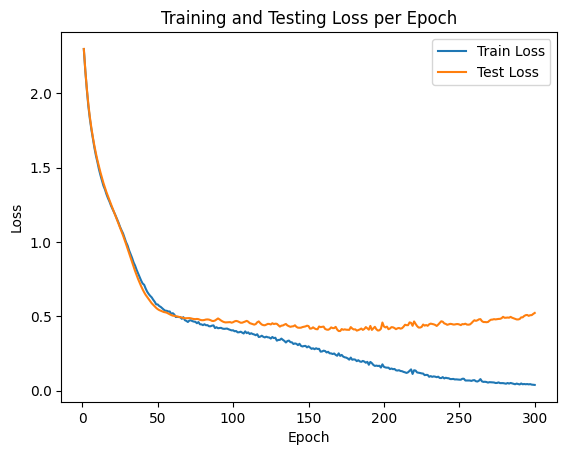

In [31]:
# Plot losses
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss')
plt.plot(range(1, len(test_losses) + 1), test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss per Epoch')
plt.legend()
plt.show()

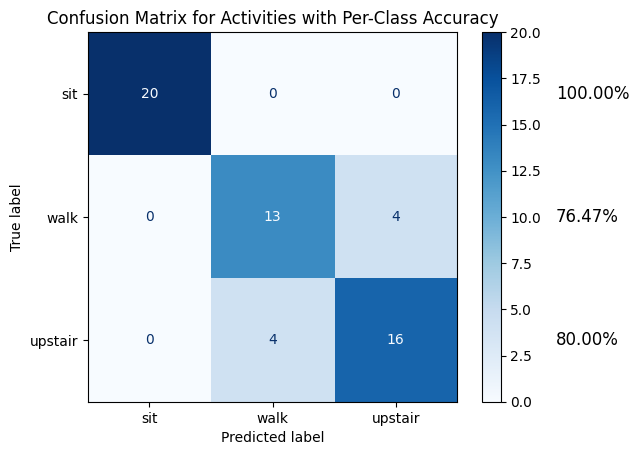

In [32]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Activities for Confusion matrix
ACTIVITIES = ['sit', 'walk','upstair']

# Model evaluation (confusion matrix)
model.eval()
all_predictions = []
all_labels = []

# Loop through the test loader to collect predictions and true labels
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.cpu().numpy())

# Compute the confusion matrix, explicitly specifying the labels
conf_matrix = confusion_matrix(all_labels, all_predictions, labels=[0, 1, 2]) 

# Assuming conf_matrix and ACTIVITIES are already defined
class_accuracies = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)  # Compute per-class accuracy

# Display the confusion matrix
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=ACTIVITIES)
fig, ax = plt.subplots()
disp.plot(cmap=plt.cm.Blues, ax=ax)

# Add per-class accuracy text
for i, activity in enumerate(ACTIVITIES):
    acc_text = f"{class_accuracies[i] * 100:.2f}%"
    ax.text(
        len(ACTIVITIES) + 0.3, i, acc_text, 
        fontsize=12, verticalalignment='center', color='black'
    )

plt.title("Confusion Matrix for Activities with Per-Class Accuracy")
plt.show()

In [33]:
import torch.nn.functional as F

model.eval()  # Set model to evaluation mode
incorrect_samples = []

with torch.no_grad():  # Disable gradient computation
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)  # Get raw logits
        probabilities = F.softmax(outputs, dim=1)  # Convert to probabilities
        predicted_labels = torch.argmax(probabilities, dim=1)  # Get predicted class
        confidence_scores = torch.max(probabilities, dim=1).values  # Get max confidence

        # Find incorrect predictions
        incorrect_indices = (predicted_labels != batch_y)
        for i in range(len(batch_y)):
            if incorrect_indices[i]:
                incorrect_samples.append({
                    "True Label": batch_y[i].item(),
                    "Predicted Label": predicted_labels[i].item(),
                    "Confidence": confidence_scores[i].item(),
                    "Probabilities": probabilities[i].tolist()
                })

for sample in incorrect_samples:
    print(f"True Label: {sample['True Label']}, Predicted: {sample['Predicted Label']}, Confidence: {sample['Confidence']:.4f}")
    print(f"Full Probabilities: {sample['Probabilities']}")

True Label: 1, Predicted: 2, Confidence: 0.9483
Full Probabilities: [1.1090045518358238e-05, 0.05171306058764458, 0.9482505321502686, 1.6183086017917958e-06, 1.2904809409519657e-05, 7.71257055021124e-06, 3.981357394877705e-07, 2.6850123049371177e-06]
True Label: 1, Predicted: 2, Confidence: 0.9532
Full Probabilities: [0.021949652582406998, 0.02394545078277588, 0.9531758427619934, 5.9593287005554885e-05, 0.0003994432627223432, 0.0004010896373074502, 1.7361004211124964e-05, 5.1631515816552565e-05]
True Label: 1, Predicted: 2, Confidence: 0.6053
Full Probabilities: [0.382885605096817, 0.009973566047847271, 0.6053200960159302, 7.666453893762082e-05, 0.0007514233002439141, 0.0009273415780626237, 2.022685657721013e-05, 4.5162469177739695e-05]
True Label: 2, Predicted: 1, Confidence: 0.9908
Full Probabilities: [4.1226962821383495e-06, 0.990790843963623, 0.009164496324956417, 1.254787775906152e-06, 2.808994395309128e-05, 9.842928193393163e-06, 4.369933037651208e-07, 8.672881222082651e-07]
True

In [ ]:
import matplotlib.pyplot as plt

chunk_sizes = [
    0.25, 0.5, 1.0, 1.375, 2.0, 2.75, 3.0, 3.5, 4.0, 5, 5.5
]
accuracies = []

for chunk_size in chunk_sizes:
    print(f"\nTesting chunk size: {chunk_size} seconds")
    
    training_data, training_labels, _ = chunk_data(training_data_raw, training_docs, chunk_size, ACTIVITIES, SAMPLING_RATE)
    testing_data, testing_labels, _ = chunk_data(testing_data_raw, testing_docs, chunk_size, ACTIVITIES, SAMPLING_RATE)
    
    training_data = np.array(training_data)
    testing_data = np.array(testing_data)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(training_data.reshape(-1, training_data.shape[-1])).reshape(training_data.shape)
    X_test = scaler.transform(testing_data.reshape(-1, testing_data.shape[-1])).reshape(testing_data.shape)
    
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(training_labels, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(testing_labels, dtype=torch.long)
    
    train_data = TensorDataset(X_train, y_train)
    test_data = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_data, batch_size=64, shuffle=True, pin_memory=True)
    test_loader = DataLoader(test_data, batch_size=64, shuffle=False, pin_memory=True)
    
    model = OptimizedCNNModel(num_classes=NUM_CLASSES, input_channels=3, seq_length=int(chunk_size * 100))
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    criterion = nn.CrossEntropyLoss()
    
    epochs = 100
    for epoch in range(epochs):
        model.train()
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
    
    test_loss, test_accuracy = evaluate_model(test_loader, model, criterion)
    accuracies.append(test_accuracy)
    print(f"Chunk size {chunk_size}s - Test Accuracy: {test_accuracy:.2f}%")

best_chunk_size = chunk_sizes[np.argmax(accuracies)]
print(f"\nBest Chunk Size: {best_chunk_size} with Test Accuracy: {max(accuracies):.2f}%")

plt.figure(figsize=(10, 5))
plt.plot(chunk_sizes, accuracies, marker='o', linestyle='-')
plt.xlabel('Chunk Size (seconds)')
plt.ylabel('Test Accuracy (%)')
plt.title('Chunk Size vs Test Accuracy')
plt.grid(True)
plt.show()


Testing chunk size: 0.25 seconds
Chunk size 0.25s - Test Accuracy: 81.19%

Testing chunk size: 0.5 seconds
Chunk size 0.5s - Test Accuracy: 77.27%

Testing chunk size: 1.0 seconds
Chunk size 1.0s - Test Accuracy: 72.22%

Testing chunk size: 1.375 seconds
